# Importing

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
bs= 32

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [30]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tarunn2799","key":"ad694e526d8ee15978f1071f2b045837"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [32]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 96% 323M/337M [00:04<00:00, 48.9MB/s]
100% 337M/337M [00:04<00:00, 83.2MB/s]


In [0]:
!unzip \*.zip

In [0]:
path= '/content/cell_images'
path_par = '/content/cell_images/Parasitized'
path_unpar = '/content/cell_images/Uninfected'

#Model

In [58]:
path= Path(path)
path

PosixPath('/content/cell_images')

In [0]:
data = ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=32, 
                                  num_workers=0).normalize(imagenet_stats)

In [0]:
print(data.classes)
data.show_batch(rows=3, figsize=(7,6))

In [0]:
malaria = cnn_learner(data, models.resnet34, metrics = accuracy)

In [66]:
malaria.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.161562,0.152903,0.947378,06:44
1,0.172540,0.122256,0.956995,06:38
2,0.143831,0.110266,0.959717,06:32
3,0.149476,0.105744,0.963346,06:13


In [0]:
malaria.save('first cycle')

In [0]:
malaria.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


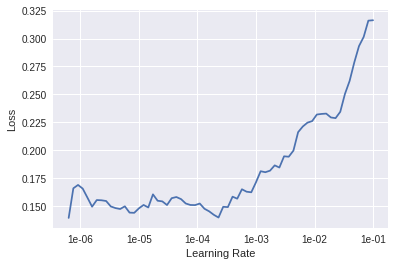

In [70]:
malaria.lr_find()
malaria.recorder.plot()

In [71]:
malaria.unfreeze()
malaria.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.132111,0.103532,0.963709,07:38
1,0.122654,0.102246,0.962620,07:34


In [0]:
malaria.save('second stage')

#Inference and Prediction

In [0]:
saved_path = Path('/content/cell_images/models/second stage')

In [0]:
interp = ClassificationInterpretation.from_learner(malaria)

In [78]:
interp.most_confused(min_val= 2)

[('Uninfected', 'Parasitized', 117), ('Parasitized', 'Uninfected', 89)]

In [0]:
pred_data= ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [0]:
predictor= cnn_learner(data, models.resnet34, metrics=accuracy, model_dir="/tmp/model/").load(saved_path)

In [0]:
pred_data.single_from_classes(path, pred_data.classes)

Category Uninfected

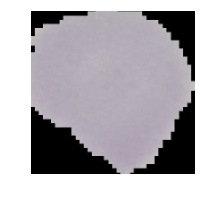

In [92]:
x,y = data.valid_ds[4]
x.show()
data.valid_ds.y[4]

In [93]:
pred_class,pred_idx,outputs = predictor.predict(x)
pred_class

Category Uninfected